In [1]:
# This is necessary in order to make the import statements work.
import sys
sys.path.append('/Users/larry/Documents/GitHub/stockpyl') # CHANGE TO YOUR DIRECTORY

In [2]:
from stockpyl import sim
from stockpyl import sim_io
from stockpyl import supply_chain_network
from stockpyl import supply_chain_node
from stockpyl import instances
from stockpyl import policy
from stockpyl import demand_source
from stockpyl import disruption_process
from stockpyl import supply_uncertainty

In [3]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [4]:
def simulation_experiment(network, num_periods, rand_seed=None):
    # Lists to iterate over.
    dt_list = ('OP', 'SP', 'TP', 'RP')
    lt_list = list(range(1, 11))

    # Progress bar.
    pbar = tqdm(total=len(dt_list)*len(lt_list))
    
    # Rand seed.
    np.random.seed(rand_seed)

    # Results.
    results = {}

    # Loop through disruption types.
    for dt in dt_list:
        results[dt] = []

        # Loop through lead times.
        for lt in lt_list:
            pbar.update()
            
            node0 = two_stage_determ.get_node_from_index(0)

            # Get optimal BS level for newsvendor problem with disruptions.
            S, _ = supply_uncertainty.newsvendor_with_disruptions(
                node0.local_holding_cost, 
                node0.stockout_cost,
                node0.demand_source.demand_list,
                node0.disruption_process.disruption_probability,
                node0.disruption_process.recovery_probability
            )

            # Fill parameters.
            node0.shipment_lead_time = lt
            node0.disruption_process.disruption_type = dt
            node0.inventory_policy.base_stock_level = S + node0.demand_source.demand_list * (lt - 1)

            # Simulate.
            total_cost = sim.simulation(network=two_stage_determ, num_periods=num_periods, rand_seed=None, progress_bar=False)

            # Store results.
            results[dt].append(total_cost/num_periods)
            
    # ``results`` is a dictionary of lists: results['OP'] is a list of costs from simulations with each lead time
    return results, lt_list

In [5]:
def plot_results(lt_list, results, title):
    # Plot results.
    plt.figure()
    #plt.plot(lt_list, results['OP'], lt_list, results['SP'], lt_list, results['TP'], lt_list, results['RP'])
    plt.plot(lt_list, results['OP'], marker='o', label='OP')
    plt.plot(lt_list, results['SP'], marker='*', label='SP')
    plt.plot(lt_list, results['TP'], marker='^', label='TP')
    plt.plot(lt_list, results['RP'], marker='x', label='RP')
    plt.legend()
    plt.xlabel('Lead Time')
    plt.ylabel('Avg. Cost/Period')
    plt.title(title)
    plt.show()

### Deterministic demand

We'll build a 2-stage system (stage 1 --> stage 0). 

* $(h_0,h_1) = (2, 1)$
* $p = 10$
* $(L_1,L_2) = (L, 1)$ ($L$ varies throughout the experiment)
* Demand is deterministic and equals 10 in every period
* Both stages follow BS policy

For the base-stock levels:
* Node 0 (downstream) acts like a single-stage (newsvendor) system with disruptions, as in Section 9.2.2 of my book, if $L=1$. If $L>1$, I don't think we have exact formulas, so I just add $10(L-1)$ to the "$L=1$" base-stock level.
* Node 1 (upstream) sees a demand of 10 in every period, even when there is a disruption, _except_ under **OP** disruptions. So I set $S_1=10$. (For **OP** disruptions, this is probably still optimal.)

Summary:
* $S_1=10$
* $S_0=NVD() + 10(L-1)$, where $NVD()$ is the optimal base-stock level for newsvendor with disruptions.

In [6]:
# Build two-stage system with deterministic demand. 1 --> 0
two_stage_determ = supply_chain_network.serial_system(
	num_nodes=2,
	local_holding_cost=[2, 1],
	stockout_cost=[10, 0],
	shipment_lead_time=[1, 1], # L_0 will be re-set during the simulation experiment
	demand_type='D',
	demand_list=[10, 0],
	inventory_policy_type='BS',
	base_stock_levels=[10, 10], # S_0 will be re-set during the simulation experiment
	downstream_0=True
)
# Downstream stage (stage 0) is subject to disruptions.
two_stage_determ.get_node_from_index(0).disruption_process = disruption_process.DisruptionProcess(
	random_process_type='M',
	disruption_type='OP', # this will be re-set during the simulation experiment
	disruption_probability=0.05,
	recovery_probability=0.3
)
# Set ITHC=0 to avoid artificial increase in cost when L increases.
for n in two_stage_determ.nodes:
	n.in_transit_holding_cost = 0

  0%|          | 0/40 [00:00<?, ?it/s]

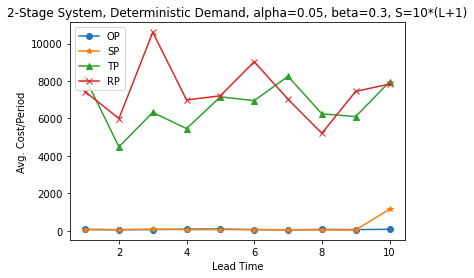

In [7]:
# Simulate with different disruption types and different lead times.
results, lt_list = simulation_experiment(two_stage_determ, num_periods=1000, rand_seed=42)
# Plot results.
plot_results(lt_list, results, '2-Stage System, Deterministic Demand, alpha=0.05, beta=0.3, S=10*(L+1)')

Disruption types **SP**, **TP**, and **RP** have the same cost. This makes sense for this simple two-stage system, because pausing shipments, pausing transit, and pausing receipt have exactly the same affect on the inventory levels at the two stages. In fact, since the demand is deterministic, 

[Why isn't cost higher in SP???]

**OP** 

In [19]:
results['TP']

[7889.5,
 6519.4,
 8269.8,
 6393.3,
 4436.9,
 7186.5,
 7196.3,
 6911.8,
 6067.7,
 6508.4]

---

### Stochastic demand

Same thing now, but with stochastic demand

In [14]:
# Build two-stage system with random demand. 1 --> 0
two_stage_stoch = supply_chain_network.serial_system(
	num_nodes=2,
	local_holding_cost=[2, 1],
	stockout_cost=[10, 2],
	shipment_lead_time=[1, 1],
	demand_type='N',
	demand_mean=[10, 0],
    demand_standard_deviation=[2, 0],
	inventory_policy_type='BS',
	base_stock_levels=[10, 10],
	downstream_0=False
)
# Downstream stage (stage 0) is subject to disruptions.
two_stage_determ.get_node_from_index(0).disruption_process = disruption_process.DisruptionProcess(
	random_process_type='M',
	disruption_type='OP',
	disruption_probability=0.05,
	recovery_probability=0.3
)
# Set ITHC=0 to avoid artificial increase in cost when L increases.
for n in two_stage_determ.nodes:
	n.in_transit_holding_cost = 0

In [15]:
# Simulate with different disruption types and different lead times.
results, lt_list = simulation_experiment(two_stage_stoch, num_periods=10000, rand_seed=42)
# Plot results.
plot_results(lt_list, results, '2-Stage System, Stochastic Demand, alpha=0.05, beta=0.3, S=10*(L+1)')

  0%|          | 0/40 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [73]:
two_stage_determ.nodes[1].index


0